In [26]:
import os
import glob

import numpy as np
import functools
import xarray as xr
import matplotlib.pyplot as plt

import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [27]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='02:00:00',                                       # Amount of wall time
    interface='ext')                                           # Interface to use

cluster.scale(10)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36267 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/36267/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/36267/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.81:39425,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/36267/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [28]:
def annual_mean(da, cf):

    days_per_month = da['time.daysinmonth']
    ann_mean = cf*(days_per_month*da).groupby('time.year').sum()
    ann_mean.name = da.name

    return ann_mean
    
def area_mean(da, biome, domain, cf, land_area):
    '''
    Calculate area mean for data_var across gridcells, either globally or by biome
    ds:        dataset
    data_var:  data variable
    domain:   'global' or 'biome'
    cfs:       unit conversion factors
    land_area: land area dataset
    '''
    
    ## update conversion factor if need be
    if cf == 'intrinsic':
        if domain == 'global':
            cf = 1/land_area.sum()
        else:
            cf = 1/land_area.groupby(biome).sum()
            
    # weight by landarea
    area_weighted = land_area*da
            
    # sort out domain groupings
    area_weighted['biome'] = biome
    area_weighted = area_weighted.swap_dims({'gridcell' : 'biome'})
    
    if domain == 'global': 
        grid = 1 + 0*area_weighted.biome  # every gridcell is in biome 1
    else: 
        grid = area_weighted.biome
    
    # calculate area mean
    area_mean = cf*area_weighted.groupby(grid).sum()
    
    if domain == 'global':
        area_mean = area_mean.mean(dim='biome')  # get rid of gridcell dimension 
        
    return area_mean
    
def calculate_vars(da, biome, domain, land_area, cf_area, cf_time, units):
    
    mean_val = annual_mean(area_mean(da, biome, domain, cf_area, land_area), cf_time)

    data_var = da.name

    # save the reduced data
    out = xr.Dataset()
    out[f'{data_var}'] = mean_val
    out[f'{data_var}'].attrs= {'units': units,
                                 'long_name': da.attrs['long_name']}


    return out

def get_map(ds, da):
    
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    out = np.zeros(sg.cclass.shape) + np.nan
    for c,(o,a) in enumerate(sg.rcent_coords):
        i = np.arange(400)[
            (abs(ds.grid1d_lat - a) < 0.1) &
            (abs(ds.grid1d_lon - o) < 0.1)]
        out[sg.cclass == c + 1] = i
    cclass = out.copy()
    cclass[np.isnan(out)] = 0

    sgmap = xr.Dataset()
    sgmap['cclass'] = xr.DataArray(cclass.astype(int), dims=['lat','lon'])
    sgmap['notnan'] = xr.DataArray(~np.isnan(out), dims=['lat','lon'])
    sgmap['lat'] = sg.lat
    sgmap['lon'] = sg.lon
    
    damap = da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()
    
    return damap

In [29]:
# whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/CLM5PPE/pyth/whit/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea  #km2

In [30]:
cfs_area = {'GPP': 1e-6,
          'LAI': 'intrinsic',
          'BTRANMN': 'intrinsic',
          'TV': 'intrinsic',
          'EFLX_LH_TOT': 'intrinsic',
          'FSH': 'intrinsic',
          'EF': 'intrinsic',
          'SOILWATER_10CM': 1e-9,
          'ASA': 'intrinsic',
          'FSR': 'intrinsic',
          'FSA': 'intrinsic',
          'FIRE': 'intrinsic',
          'RLNS': 'intrinsic',
          'RN': 'intrinsic',
          'TBOT': 'intrinsic'}
cfs_time = {'GPP': 24*60*60,
          'BTRANMN': 1/365,
          'TV': 1/365,
          'LAI': 1/365,
          'EFLX_LH_TOT': 1/365,
          'FSH': 1/365,
          'EF': 1/365,
          'SOILWATER_10CM': 1/365,
          'ASA': 1/365,
          'FSR': 1/365,
          'FSA': 1/365,
          'FIRE': 1/365,
          'RLNS': 1/365,
          'RN': 1/365,
          'TBOT': 1/365}
var_units = {'GPP': 'PgC yr$^{-1}$',
          'BTRANMN': '',
          'TV': 'K',
          'LAI': 'm$^2$ m$^{-2}$',
          'EFLX_LH_TOT': 'W m$^{-2}$',
          'FSH': 'W m$^{-2}$',
          'EF': '',
          'SOILWATER_10CM': 'TtH$_2$O yr$^{-1}$',
          'ASA': '',
          'FSR': 'W m$^{-2}$',
          'FSA': 'W m$^{-2}$',
          'FIRE': 'W m$^{-2}$',
          'RLNS': 'W m$^{-2}$',
          'RN': 'W m$^{-2}$',
          'TBOT': 'K'}

In [31]:
hist_dir = '/glade/work/afoster/FATES_calibration/old_calib/FATES_SP_LH/transient_hist_co2'
files = sorted([os.path.join(hist_dir, f) for f in os.listdir(hist_dir)])

In [32]:
ds = xr.open_mfdataset(files, combine='nested', concat_dim='ensemble', parallel=True)
ds['biome'] = whittaker_ds.biome
ds['biome_name'] = whittaker_ds.biome_name

In [33]:
ds = ds.sel(time=slice('2015-01-01', '2100-12-31'))

In [ ]:
# ds.isel(ensemble=slice(1, 101))

In [34]:
var = 'EFLX_LH_TOT'
data = calculate_vars(ds[var], ds.biome, 'global', land_area, cfs_area[var],
                      cfs_time[var], var_units[var]).compute()

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 67.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [35]:
ensemble_mean = data[var].mean(dim='ensemble')

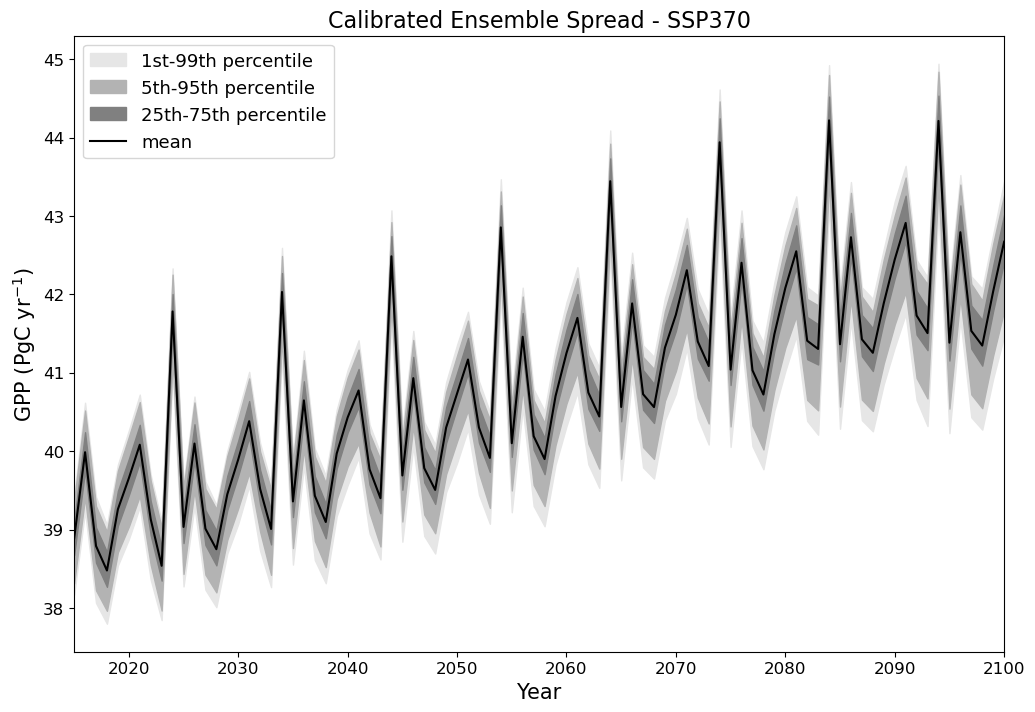

In [36]:
fig = plt.figure(figsize=(12, 8))

year = sorted(np.unique(data.year))

quantiles = [1, 5, 25]
colors = [0.9, 0.7, 0.5]
labels = ['1st-99th percentile', '5th-95th percentile', '25th-75th percentile']

for i, quantile in enumerate(quantiles):
    q1 = data[var].chunk(dict(ensemble=-1, year=-1)).quantile(quantile/100, dim='ensemble')
    q2 = data[var].chunk(dict(ensemble=-1, year=-1)).quantile(1 - quantile/100, dim='ensemble')
    plt.fill_between(year, q1, q2, color=colors[i]*np.ones(3), label=labels[i])
    
plt.plot(year, ensemble_mean, color='k', zorder=2, label='mean')
plt.xlim([2015, 2100])
#plt.ylim([100, 125])
plt.legend(loc='upper left', fontsize=13)
plt.xlabel('Year', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('GPP (PgC yr$^{-1}$)', fontsize=15)
plt.title('Calibrated Ensemble Spread - SSP370', fontsize=16);
#plt.savefig('output_gcm_et.png')

In [20]:
hist_dir0 = '/glade/work/afoster/FATES_calibration/old_calib/FATES_SP_LH/transient_hist'
files0 = sorted([os.path.join(hist_dir0, f) for f in os.listdir(hist_dir0)])

In [21]:
ds0 = xr.open_mfdataset(files0[1:], combine='nested', concat_dim='ensemble', parallel=True)
ds0['biome'] = whittaker_ds.biome
ds0['biome_name'] = whittaker_ds.biome_name

In [22]:
ds0 = ds0.sel(time=slice('2015-01-01', '2100-12-31'))

In [23]:
var = 'GPP'
data0 = calculate_vars(ds0[var], ds.biome, 'global', land_area, cfs_area[var],
                      cfs_time[var], var_units[var]).compute()

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 59.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [24]:
ensemble_mean0 = data0[var].mean(dim='ensemble')

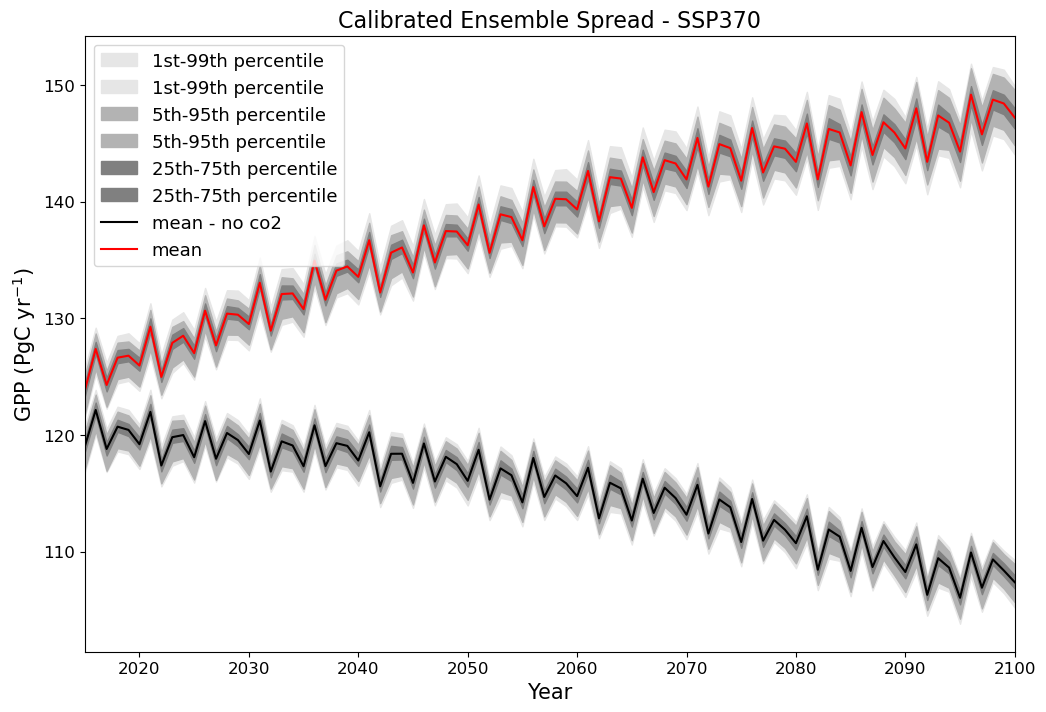

In [25]:
fig = plt.figure(figsize=(12, 8))

year = sorted(np.unique(data.year))

quantiles = [1, 5, 25]
colors = [0.9, 0.7, 0.5]
labels = ['1st-99th percentile', '5th-95th percentile', '25th-75th percentile']

for i, quantile in enumerate(quantiles):
    q1 = data[var].chunk(dict(ensemble=-1, year=-1)).quantile(quantile/100, dim='ensemble')
    q2 = data[var].chunk(dict(ensemble=-1, year=-1)).quantile(1 - quantile/100, dim='ensemble')
    plt.fill_between(year, q1, q2, color=colors[i]*np.ones(3), label=labels[i])

    q10 = data0[var].chunk(dict(ensemble=-1, year=-1)).quantile(quantile/100, dim='ensemble')
    q20 = data0[var].chunk(dict(ensemble=-1, year=-1)).quantile(1 - quantile/100, dim='ensemble')
    plt.fill_between(year, q10, q20, color=colors[i]*np.ones(3), label=labels[i])
    
plt.plot(year, ensemble_mean0, color='k', zorder=2, label='mean - no co2')
plt.plot(year, ensemble_mean, color='r', zorder=2, label='mean')
plt.xlim([2015, 2100])
#plt.ylim([100, 125])
plt.legend(loc='upper left', fontsize=13)
plt.xlabel('Year', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('GPP (PgC yr$^{-1}$)', fontsize=15)
plt.title('Calibrated Ensemble Spread - SSP370', fontsize=16);
# plt.savefig('output_gcm.png')